In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.cluster import KMeans

In [3]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [4]:
# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [5]:
# Calculate tenure (days since signup to last transaction)
latest_transaction_date = transactions['TransactionDate'].max()
customers['Tenure'] = (latest_transaction_date - customers['SignupDate']).dt.days

In [6]:
# Aggregate transaction data per customer
customer_agg = transactions.groupby('CustomerID').agg(
    Total_Transactions=('TransactionID', 'nunique'),
    Total_Spent=('TotalValue', 'sum'),
    Avg_Quantity=('Quantity', 'mean'),
    Unique_Products=('ProductID', 'nunique')
).reset_index()

# Merge customer data with aggregated transaction data
customer_features = pd.merge(customers, customer_agg, on='CustomerID')

In [7]:
# Encode 'Region' (categorical feature)
encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(customer_features[['Region']]).toarray()
encoded_region_df = pd.DataFrame(encoded_region, columns=encoder.get_feature_names_out(['Region']))

In [8]:
# Combine features
customer_features = pd.concat([customer_features, encoded_region_df], axis=1)
customer_features.drop('Region', axis=1, inplace=True)

In [9]:
# Select numerical features and standardize
features = customer_features[['Tenure', 'Total_Transactions', 'Total_Spent', 'Avg_Quantity', 'Unique_Products'] + list(encoded_region_df.columns)]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [10]:
scaled_features

array([[ 1.148752  , -0.01145819, -0.06170143, ..., -0.57928445,
        -0.54831888,  1.54041597],
       [ 1.60043068, -0.46749414, -0.87774353, ..., -0.57928445,
        -0.54831888, -0.6491753 ],
       [-0.71327032, -0.46749414, -0.40585722, ..., -0.57928445,
        -0.54831888,  1.54041597],
       ...,
       [ 1.55741366, -1.37956603, -1.38697529, ...,  1.72626765,
        -0.54831888, -0.6491753 ],
       [ 0.70014596, -0.46749414, -0.81399315, ...,  1.72626765,
        -0.54831888, -0.6491753 ],
       [ 0.11634358, -0.01145819,  0.70636652, ..., -0.57928445,
        -0.54831888, -0.6491753 ]], shape=(199, 9))

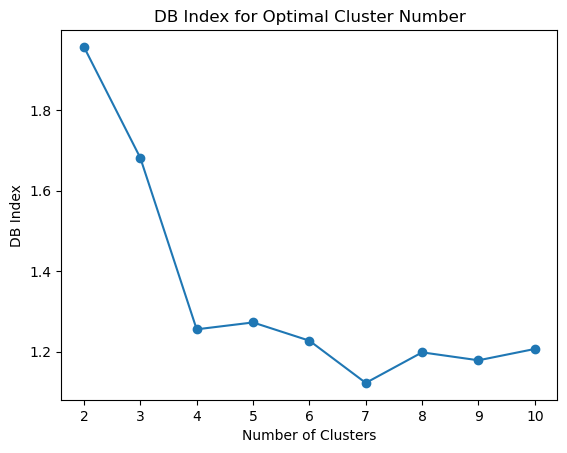

In [13]:
# Calculate DB Index for k=2 to k=10
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=72, n_init='auto')  # Use n_init='auto'
    clusters = kmeans.fit_predict(scaled_features)
    db_scores.append(davies_bouldin_score(scaled_features, clusters))


plt.plot(range(2, 11), db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.title('DB Index for Optimal Cluster Number')
plt.show()

- Optimal low DB occurs at k=4.

In [19]:
# Apply K-Means with optimal k=4
kmeans = KMeans(n_clusters=4, random_state=72)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

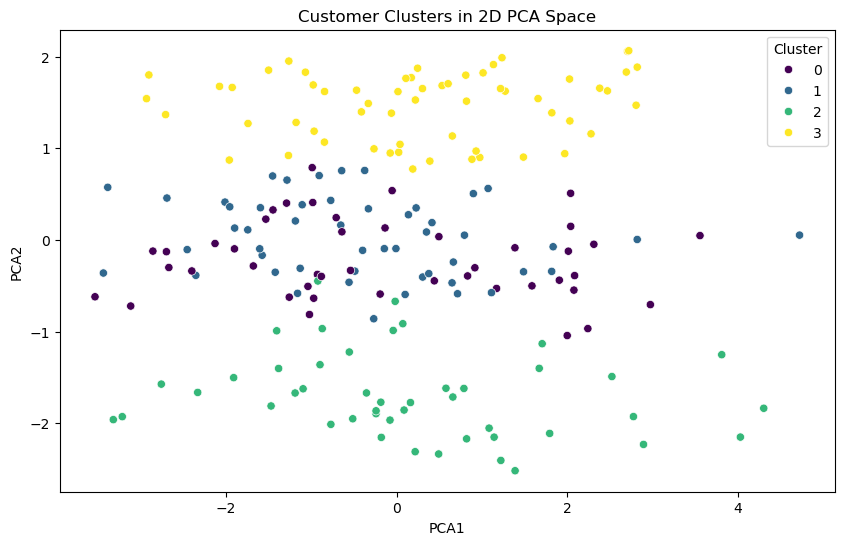

In [20]:
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
customer_features['PCA1'] = principal_components[:, 0]
customer_features['PCA2'] = principal_components[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='viridis')
plt.title('Customer Clusters in 2D PCA Space')
plt.show()

- Note: Tenure is in no of  days

In [21]:
# Analyze cluster profiles
cluster_summary = customer_features.groupby('Cluster').agg({
    'Tenure': 'mean',
    'Total_Transactions': 'mean',
    'Total_Spent': 'mean',
    'Avg_Quantity': 'mean',
    'Unique_Products': 'mean'
}).reset_index()

cluster_summary.round(2)

,Cluster,Tenure,Total_Transactions,Total_Spent,Avg_Quantity,Unique_Products
0,0,521.98,4.95,3456.25,2.55,4.73
1,1,548.08,4.68,3325.09,2.52,4.62
2,2,422.22,5.30,3311.16,2.47,5.26
3,3,598.41,5.15,3717.84,2.58,4.97


- Cluster 0: Moderate Spenders
- Cluster 1: Low Engagement Customers
- Cluster 2: Frequent Shoppers
- Cluster 3: High Value Customers